In [22]:
import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F
import math

import numpy as np
import sklearn.datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR

In [23]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

In [24]:
torch.manual_seed(1)
np.random.seed(1)

# hyper parameters used in toy example
nb_proto=10
nb_layer=20
n_samples=10000
dist='cos'
loss_uncer_param=1
loss_proto_param=0.1
loss_entropy_param=20
num_classes = 2
batch_size = 64


nb_PC=2 # nb components of PCA

Softmax = nn.Softmax(dim=1)

# creating the dataset
noise = 0.1
X_train, y_train = sklearn.datasets.make_moons(n_samples=n_samples, noise=noise)
X_test, y_test = sklearn.datasets.make_moons(n_samples=200, noise=noise)
ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)
ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=200, shuffle=False)

# creating the ood data (won't be used in any training, will be used just in illustrations)
ood_x, _ = sklearn.datasets.make_circles(n_samples=200,shuffle=True, noise=0.05, random_state=42, factor=0.99)
ood_x = ood_x * 3.5

In [25]:
# We build two MLPs, one with DM and one without
def centered_cov_torch(x):
    n = x.shape[0]
    res = 1 /n * x.t().mm(x)
    #res = x.t().mm(x)
    return res

def normpdf(x, gaussian):
    n = x.shape[0]
    var = 0.1#float(sd)**2

    out=[]
    for i in range(n):
        num =np.exp(-0.5*np.matmul(np.matmul((x[i]-gaussian['mean']), gaussian['cov_inv']),np.transpose((x[i]-gaussian['mean']))))/gaussian['denom']
        #print(np.shape(num),num)
        out.append(num)
    out=np.array(out)

    return out

class Distanceminimi_Layer_learned(nn.Module):
    def __init__(self, in_features=0, out_features=0, dist='lin'):
        super(Distanceminimi_Layer_learned, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dist=dist
        self.omega = nn.Parameter(torch.Tensor(out_features, in_features))

        self.reset_parameters()

    def reset_parameters(self):

        nn.init.normal_(self.omega, mean=0, std=1)#/self.out_features)

    def forward(self, x):
        prots = self.omega.unsqueeze(0)
        x = x.unsqueeze(1)
        
        if self.dist == 'l2':
            x = -torch.pow(x - prots, 2).sum(-1)  # shape [n_query, n_way]
        elif self.dist == 'cos':
            x = F.cosine_similarity(x, prots, dim=-1, eps=1e-30)
        elif self.dist == 'lin':
            x = torch.einsum('izd,zjd->ij', x, prots)
        return x

    
# MLP with DM
class Model(nn.Module):
    def __init__(self, features, nb_prototype,dist='cos'):
        super().__init__()
        
        self.fc1 = nn.Linear(2, features)
        self.fc2 = nn.Linear(features, features)
        self.fc3 = nn.Linear(features, features)
        self.dist =dist
        self.DMlayer = Distanceminimi_Layer_learned(in_features = features, out_features = nb_prototype, dist=dist)
        self.DMBN = nn.BatchNorm1d(nb_prototype)
        self.linear1  = nn.Linear(nb_prototype, features)
        self.linear2  = nn.Linear(features, 1)
        
        self.fc4 = nn.Linear(nb_prototype, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x1 = self.DMlayer(x)
        if self.dist=='cos' :x2 = torch.exp(-x1)
        else :x2 = torch.exp(x1)
        x2_bn = self.DMBN(x2)
        uncer = F.relu(self.linear1(x2_bn))
        uncer = self.linear2(uncer).squeeze()
        pred = self.fc4(x2_bn)
        
        return pred, uncer, x, x1, x2

    def forward_conf(self, x):
        x1 = self.DMlayer(x)
        if self.dist == 'cos':
            x2 = torch.exp(-x1)
        else:
            x2 = torch.exp(x1)
        x2 = self.DMBN(x2)
        x2 = F.relu(self.linear1(x2))
        uncer = self.linear2(x2).squeeze()
        return uncer

    def loss_kmeans(self):
        param = self.DMlayer.omega
        loss = torch.mean(torch.cdist(param, param))
        return loss


In [26]:
def train(model, train_loader, optimizer, epoch,log_interval=20):
    model.train()
    correct = 0
    total=0
    for batch_idx, data in enumerate(train_loader, 0):

        x, y  = data
        # x, y = x.cuda(), y.cuda()

        model.zero_grad()

        y_pred, uncer, embedding, embeddingDM, _ = model(x)
        loss_pred =  F.cross_entropy(y_pred, y, reduction='none')
        loss_detach = loss_pred.detach()
        loss_detach = loss_detach - loss_detach.min()
        loss_detach = loss_detach/loss_detach.max()
        loss_proto = model.loss_kmeans()
        # loss_uncer = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.01]).cuda())(uncer, loss_detach)
        loss_uncer = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.01]))(uncer, loss_detach)

        embeddings_proba = Softmax(embeddingDM)
        embeddings_entropy = torch.sum(embeddings_proba * torch.log(embeddings_proba), dim=1)
        loss_entropy = torch.mean(embeddings_entropy)
        
        loss = loss_pred.mean() + loss_uncer*loss_uncer_param - loss_proto_param*loss_proto + loss_entropy_param*loss_entropy
        loss.backward()
        optimizer.step()

        y_pred = torch.max(y_pred, dim=1)[1]
        correct += y_pred.eq(y.data).cpu().sum()
        total += y.size(0)
        acc = 100.*correct/total
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tACCU: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item(), acc.item() ))

    return acc.item()

def test(model, test_loader, epoch):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            x, y  = data
            # x, y = x.cuda(), y.cuda()
            y_pred, _, _, _, _ = model(x)
            y_pred = Softmax(y_pred)
            y_pred = torch.max(y_pred, dim=1)[1]

            correct += y_pred.eq(y.data).cpu().sum()
            total += y.size(0)
        acc = 100.*correct/total
        print('Test Epoch: {} \t ACCU: {:.6f}'.format(epoch, acc))
    return acc 

#### Training DNN with DM layer

In [27]:
# we perfom a training of the MODEL with DM
num_epochs = 17
model = Model(nb_layer, nb_proto,dist)
# model = model.cuda()
train_history = []
val_history = []
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
for epoch in range(num_epochs):
    acc = train(model, dl_train, optimizer, epoch)
    train_history.append(acc)
    acc=test(model, dl_test, epoch)
    val_history.append(acc)

Train Epoch: 0 [0/10000 (0%)]	Loss: -45.230042 	ACCU: 45.312500
Train Epoch: 0 [1280/10000 (13%)]	Loss: -46.104664 	ACCU: 79.910713
Train Epoch: 0 [2560/10000 (26%)]	Loss: -46.485287 	ACCU: 88.185974
Train Epoch: 0 [3840/10000 (38%)]	Loss: -46.564323 	ACCU: 91.956970
Train Epoch: 0 [5120/10000 (51%)]	Loss: -46.530388 	ACCU: 93.750000
Train Epoch: 0 [6400/10000 (64%)]	Loss: -46.578106 	ACCU: 94.910271
Train Epoch: 0 [7680/10000 (77%)]	Loss: -46.585987 	ACCU: 95.674072
Train Epoch: 0 [8960/10000 (90%)]	Loss: -46.615837 	ACCU: 96.276596
Test Epoch: 0 	 ACCU: 99.500000
Train Epoch: 1 [0/10000 (0%)]	Loss: -46.607166 	ACCU: 98.437500
Train Epoch: 1 [1280/10000 (13%)]	Loss: -46.629292 	ACCU: 99.851189
Train Epoch: 1 [2560/10000 (26%)]	Loss: -46.639721 	ACCU: 99.695122
Train Epoch: 1 [3840/10000 (38%)]	Loss: -46.640274 	ACCU: 99.667007
Train Epoch: 1 [5120/10000 (51%)]	Loss: -46.652302 	ACCU: 99.652779
Train Epoch: 1 [6400/10000 (64%)]	Loss: -46.652969 	ACCU: 99.675125
Train Epoch: 1 [7680/100

/var/folders/f2/kxwqn1yx45q6zj509rmy6g0m0000gq/T/ipykernel_88897/1470632885.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = y_vis.astype(np.bool)


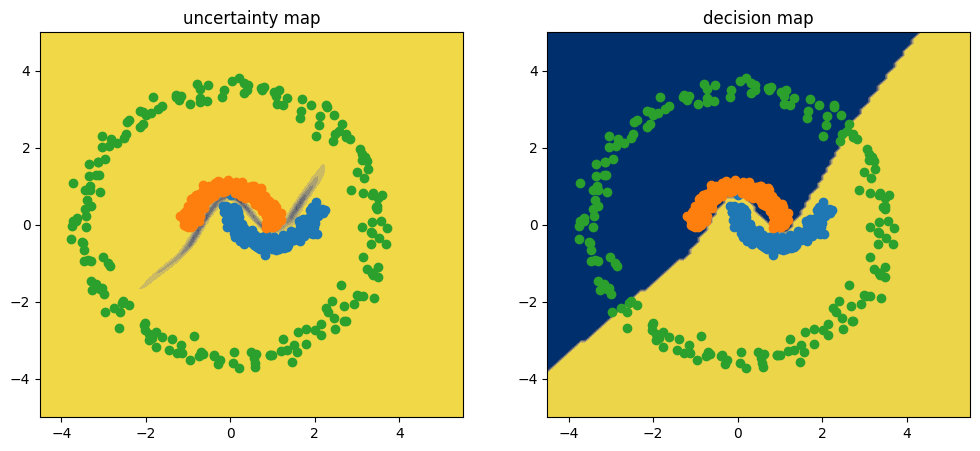

In [28]:
# we perfom an evaluation of the MODEL with DM

# we build the test set
domain = 5
x = np.linspace(-domain+0.5, domain+0.5, 100)
y = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x, y)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])
X = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=500, noise=noise)
mask = y_vis.astype(np.bool)

model.eval()
# we evaluate on the test set
with torch.no_grad():
    
    # output, confidence, embedding, embeddingDM, _ = model(torch.from_numpy(X_grid).float().cuda())
    output, confidence, embedding, embeddingDM, _ = model(torch.from_numpy(X_grid).float())
    output = torch.max(output, dim=1)
    confidence = 1 - nn.Sigmoid()(confidence)

confidence = confidence.reshape(xx.shape).cpu()
output = output[1].reshape(xx.shape).cpu()
# we visualize
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.contourf(x, y, confidence, cmap='cividis')
plt.scatter(X_vis[mask,0], X_vis[mask,1])
plt.scatter(X_vis[~mask,0], X_vis[~mask,1])
plt.scatter(ood_x[:,0], ood_x[:,1])
plt.title('uncertainty map')

plt.subplot(1, 2, 2)
plt.contourf(x, y, output, cmap='cividis')
plt.scatter(X_vis[mask, 0], X_vis[mask, 1])
plt.scatter(X_vis[~mask, 0], X_vis[~mask, 1])
plt.scatter(ood_x[:,0], ood_x[:,1])
plt.title('decision map')

name = 'results_uncer_BEFORE_training_gaussian.pdf'
fig.savefig(name, dpi=200)




In [29]:
# we save the model
modelsave = Model(nb_layer, nb_proto,dist)
modelsave.load_state_dict(model.state_dict())

<All keys matched successfully>

#### Optional: Fine-tuning g_unc in DNN with DM layer

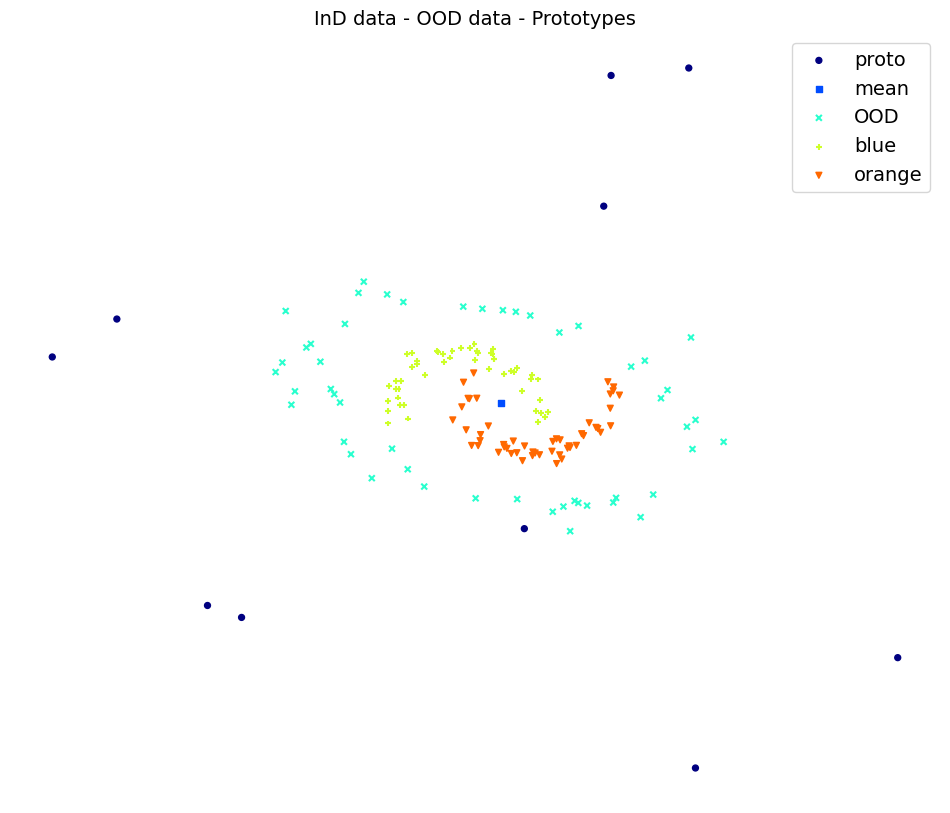

In [30]:
# we build OOD data to train the g^{unce} for OOD
# Our OOD process generation is inspired by https://arxiv.org/abs/2202.01197
# we concatenate the latent space of the training dataset

with torch.no_grad():
    # output, confidence, z_train, embeddingDM,_ = model(torch.from_numpy(X_train).float().cuda())
    output, confidence, z_train, embeddingDM,_ = model(torch.from_numpy(X_train).float())

prototypes = model.DMlayer.omega


z_embed = torch.from_numpy(X_train) # z_embed is the embedding of the DNN

#  we apply a PCA on this space to have a better representation
pca = PCA(n_components=nb_PC).fit(prototypes.detach().cpu().numpy())
prototypes_embed=pca.fit_transform(prototypes.detach().cpu().numpy())
prototypes_embed=torch.from_numpy(prototypes_embed)


mean_data = torch.mean(z_embed, dim=0)
mean_data_numpy = mean_data.cpu().numpy().astype(np.float32)
covariance =centered_cov_torch(z_embed-mean_data).cpu().numpy().astype(np.float32)
covariance += 0.01 * np.eye(nb_PC, dtype=float)
covariance_INV = np.linalg.inv(covariance)
denom = np.linalg.det((2 * math.pi * covariance)) ** 0.5

#  we build a gaussian ditribution representing the dataset
gaussian={"mean":mean_data_numpy,"cov":covariance,
          "cov_inv":covariance_INV,"denom":denom}
#  we sample data according to the gaussian distribution
x = np.random.multivariate_normal(gaussian['mean'], gaussian['cov'], (n_samples*2000))
proba = normpdf(x, gaussian)
#   we take the less probable data which represent OOD
x_sample = x[proba < 1.0e-2]
x_sample_OOD=x_sample[0:n_samples+200]
x_sample_OOD_train=x_sample_OOD[0:n_samples]
x_sample_OOD_val=x_sample_OOD[n_samples:]

z_embed = torch.cat((prototypes_embed, z_embed), 0)
z_embed2 = z_embed.clone().numpy()
#   we  concatenate everything for visualization
z_embed=np.concatenate((z_embed2[0:nb_proto],np.expand_dims(mean_data, axis=0),x_sample_OOD,z_embed2[nb_proto:]),axis=0)

#   we visualise the results
class_proto=np.zeros(nb_proto+1)
class_proto[nb_proto]=1
class_OOD=2*np.ones(len(x_sample_OOD))
y_train2 = np.concatenate((class_proto,class_OOD, y_train+3), axis=0)

classes = ['proto','mean','OOD','blue', 'orange']
fig = plt.figure(figsize=(12, 10))
plots = []
markers = ['o', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd']
for i, c in enumerate(classes):
    ind = (y_train2 == i).tolist()
    color = cm.jet([i / len(classes)] * sum(ind))
    if i==0:
        #color = cm.jet([i / len(classes)] * sum(ind))
        plots.append(plt.scatter(z_embed[ind, 0], z_embed[ind, 1], marker=markers[i], c=color, s=18, label=i))
    else :
        plots.append(plt.scatter(z_embed[ind, 0][0:50], z_embed[ind, 1][0:50], marker=markers[i], c=color[0:50], s=18, label=i))

plt.axis('off')
plt.legend(plots, classes, fontsize=14, loc='upper right')
plt.title('InD data - OOD data - Prototypes', fontsize=14)
plt.show()


In [31]:
#   we build a new trainig set.
x_sample_OOD_train_1 = torch.from_numpy(x_sample_OOD_train).float()
X_train_ind = torch.from_numpy(X_train).float()
X_train0 = torch.cat((X_train_ind, x_sample_OOD_train_1))
y_train1 = torch.zeros_like(X_train_ind[:,0])
y_train2 = torch.ones_like(x_sample_OOD_train_1[:,0])
y_train0 = torch.cat((y_train1, y_train2))

x_sample_OOD_val_1 = torch.from_numpy(x_sample_OOD_val).float()
X_test_ind = torch.from_numpy(X_test).float()
X_test0 = torch.cat((X_test_ind, x_sample_OOD_val_1))
y_test1 = torch.zeros_like(X_test_ind[:,0])
y_test2 = torch.ones_like(x_sample_OOD_val_1[:,0])
y_test0 = torch.cat((y_test1, y_test2))

ds_train = torch.utils.data.TensorDataset(X_train0, y_train0)
dl_train_ood = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

ds_test = torch.utils.data.TensorDataset(X_test0, y_test0)
dl_test_ood = torch.utils.data.DataLoader(ds_test, batch_size=200, shuffle=False)

In [32]:
criterionBCE = nn.BCEWithLogitsLoss() 
def train( model, train_loader, optimizer, epoch,log_interval=20):
    model.train()
    loss_cpu=0
    correct = 0
    total=0
    for batch_idx, data in enumerate(train_loader, 0):

        x, y  = data
        # x, y = x.cuda(), y.cuda()

        model.zero_grad()

        _, uncer, _, _ , _ = model(x)
        loss = criterionBCE(uncer, y)

        loss.backward()
        optimizer.step()

        loss_cpu+=loss.cpu().item()
        uncer_pred = torch.sigmoid(uncer).detach()
        uncer_pred = (uncer_pred>0.5).long()
        correct += uncer_pred.eq(y.data).cpu().sum()
        total += y.size(0)
        acc = 100.*correct/total
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tACCU: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item(), acc.item() ))

    return acc.item()

def test(model, test_loader,epoch):
    model.eval()

    test_loss_MSE =0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            x, y  = data
            # x, y = x.cuda(), y.cuda()
            _, uncer_pred, _, _ , _ = model(x)
            uncer_pred = nn.Sigmoid()(uncer_pred)
            uncer_pred = (uncer_pred>0.5).long()

            correct += uncer_pred.eq(y.data).cpu().sum()
            total += y.size(0)
        # Save checkpoint when best model
        acc = 100.*correct/total
        print('Test Epoch: {} \t ACCU: {:.6f}'.format(epoch, acc))
    return acc 

In [33]:
#   we train g^{unce} to detect  OOD data
num_epochs=35
# model=model.cuda()
train_history = []
val_history = []
model.load_state_dict(modelsave.state_dict())
# just fine tune the g_unc
param = list(model.linear1.parameters()) + list(model.linear2.parameters())
optimizer = torch.optim.Adam(param, lr=0.001,  weight_decay=1e-3)
lr_scheduler =  StepLR(optimizer, step_size=14, gamma=10)

for epoch in range(num_epochs):
    

    acc = train(model, dl_train_ood, optimizer, epoch)
    train_history.append(acc)
    acc=test(model, dl_test_ood,epoch)
    lr_scheduler.step()
    val_history.append(acc)


Train Epoch: 0 [0/20000 (0%)]	Loss: 5.198268 	ACCU: 50.000000
Train Epoch: 0 [1280/20000 (6%)]	Loss: 4.361307 	ACCU: 50.967262
Train Epoch: 0 [2560/20000 (13%)]	Loss: 3.518105 	ACCU: 50.571648
Train Epoch: 0 [3840/20000 (19%)]	Loss: 2.698995 	ACCU: 50.665985
Train Epoch: 0 [5120/20000 (26%)]	Loss: 2.539260 	ACCU: 50.925926
Train Epoch: 0 [6400/20000 (32%)]	Loss: 2.179426 	ACCU: 50.680695
Train Epoch: 0 [7680/20000 (38%)]	Loss: 1.838723 	ACCU: 50.710228
Train Epoch: 0 [8960/20000 (45%)]	Loss: 1.951624 	ACCU: 50.387856
Train Epoch: 0 [10240/20000 (51%)]	Loss: 1.344417 	ACCU: 50.349380
Train Epoch: 0 [11520/20000 (58%)]	Loss: 0.788575 	ACCU: 50.457527
Train Epoch: 0 [12800/20000 (64%)]	Loss: 0.695480 	ACCU: 50.373135
Train Epoch: 0 [14080/20000 (71%)]	Loss: 0.499265 	ACCU: 51.463516
Train Epoch: 0 [15360/20000 (77%)]	Loss: 0.379791 	ACCU: 53.565872
Train Epoch: 0 [16640/20000 (83%)]	Loss: 0.457200 	ACCU: 55.950672
Train Epoch: 0 [17920/20000 (90%)]	Loss: 0.395611 	ACCU: 58.285141
Train Ep

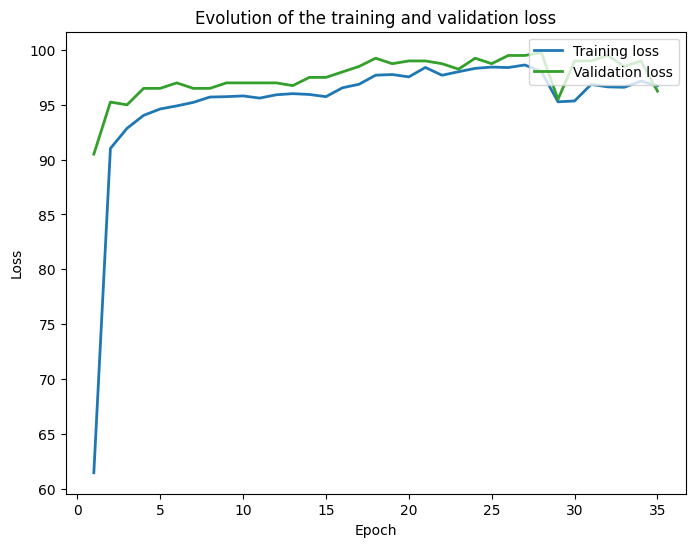

In [34]:
#   we  vizualise the training curb
plot_losses(train_history, val_history)

/var/folders/f2/kxwqn1yx45q6zj509rmy6g0m0000gq/T/ipykernel_88897/301012446.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = y_vis.astype(np.bool)


CHECKING confidence tensor([0., 0., 0.,  ..., 0., 0., 0.]) (min,max )= 0.0 1.0


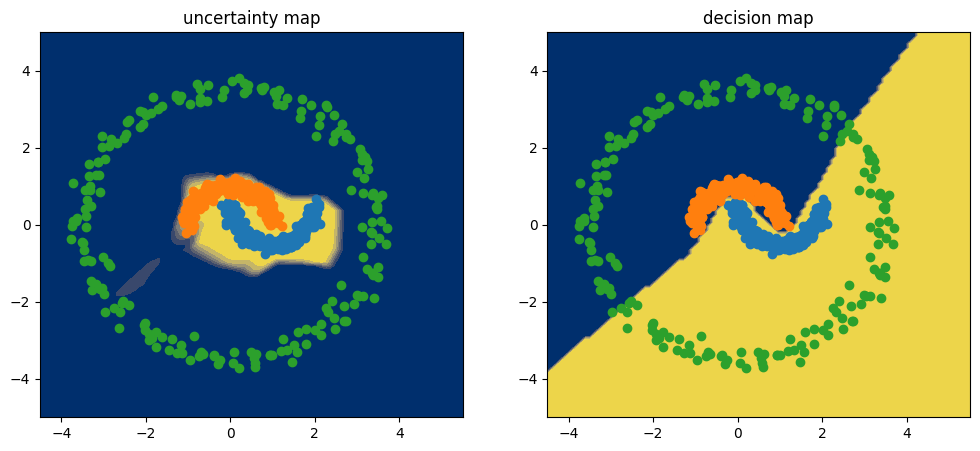

In [35]:
#   we  plot the uncertainty curb

domain = 5
x = np.linspace(-domain+0.5, domain+0.5, 100)
y = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x, y)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])
X = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=500, noise=noise)
mask = y_vis.astype(np.bool)

model.eval()
with torch.no_grad():
    # output, confidence, embedding, embeddingDM, _ = model(torch.from_numpy(X_grid).float().cuda())
    output, confidence, embedding, embeddingDM, _ = model(torch.from_numpy(X_grid).float())
    output = torch.max(output, dim=1)
    confidence = 1 - nn.Sigmoid()(confidence)
print('CHECKING confidence',confidence,'(min,max )=',confidence.min().item(),confidence.max().item())

confidence = confidence.reshape(xx.shape).cpu()
output = output[1].reshape(xx.shape).cpu()

fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.contourf(x, y, confidence, cmap='cividis')
plt.scatter(X_vis[mask, 0], X_vis[mask, 1])
plt.scatter(X_vis[~mask, 0], X_vis[~mask, 1])
plt.scatter(ood_x[:,0], ood_x[:,1])
plt.title('uncertainty map')

plt.subplot(1, 2, 2)
plt.contourf(x, y, output, cmap='cividis')
plt.scatter(X_vis[mask, 0], X_vis[mask, 1])
plt.scatter(X_vis[~mask, 0], X_vis[~mask, 1])
plt.scatter(ood_x[:,0], ood_x[:,1])
plt.title('decision map')

name = 'results_uncer_AFTERtraining_gaussian_ANDPCA.png'
fig.savefig(name, dpi=200)
